# Memoji Generation using GANs

Memojis (or emojis) have become a significant part of our daily communication. They are a fun way to express our emotions and feelings. They also are a significant product of companies like Apple, Samsung and Google.

The challenge with creating Memojis is that they are unique to each person. This makes it difficult to create a general model that can generate Memojis for everyone. However, we can create a model that can generate Memojis that look like the actual person. They can resemble the person in terms of their hair colour, skin tone etc.

For this deep learning project, we will use a Generative Adversarial Network (GAN) to generate Memojis. We will use a dataset of images of people's faces to train the GAN. The GAN will learn the features of the faces and generate Memojis that look like the faces in the dataset.

## What is a GAN?

A Generative Adversarial Network (GAN) is a type of deep learning model that is used to generate new data samples. It consists of two neural networks - a generator and a discriminator. The generator generates new data samples, while the discriminator tries to distinguish between real data samples and generated data samples. The two networks are trained together in a competitive setting, where the generator tries to fool the discriminator, and the discriminator tries to detect the generated data samples.

## Dataset

For this project we will be using not one but two datasets. They are:  

- **CelebA Dataset**: This dataset contains over 2,000,000 celebrity images with annotations. We will use this dataset to train the GAN to learn the features of human faces.
- **Cartoonset**: This dataset by Google contains over $10 ^ {13}$ images of emojis that each represent various features of a person. This dataset was indeed used a build a ML model for **Google Allo**.

## Inspiration

![alt text](https://miro.medium.com/v2/resize:fit:916/format:webp/1*BXpjDD0O9YsTtVGvX62EeA.png)

The GAN model consists of two neural networks - a generator and a discriminator. The generator takes random noise as input and generates new data samples, while the discriminator takes data samples and tries to distinguish between real data samples and generated data samples.

- In our project, we will try to use the paper [CycleGAN](https://arxiv.org/abs/1703.10593) to generate Memojis. CycleGAN is a type of GAN that is used for image-to-image translation. It can learn to translate images from one domain to another without paired examples. This means that we can train the GAN on images of human faces and generate Memojis that look like the faces.

- There are 2 Generators and 2 Discriminators in CycleGAN. The generators are responsible for translating images from one domain to another, while the discriminators are responsible for distinguishing between real and generated images.
![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*jE6KgUrOSUM2lkLRWGwO4g.png)

- Although for our use case, we only need one generator and one discriminator, we will still use the architecture of CycleGAN to generate Memojis.

![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*KTWjn-D8GijMnzX7IRpN6g.png)

### Generator Architecture
![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*xpzrkhjToausfj16.png)

In [1]:
import os
import random
import typing
import warnings
from typing import Tuple

import lightning as L
import lightning.pytorch.callbacks as pl_callbacks
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.io as tio
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F

%matplotlib inline

RANDOM_SEED = 42

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

warnings.filterwarnings("ignore")

DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

if DEVICE == "mps":
    torch.mps.empty_cache()

In [2]:
INIT_MEAN: float = 0.0
INIT_STD: float = 0.02

In [3]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        use_reversed_layer: bool = False,
        use_leaky_relu: bool = False,
        leaky_relu_slope: float = 0.2,
    ):
        super(ConvolutionalBlock, self).__init__()

        self.layers = nn.Sequential(
            (
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    padding_mode="zeros",
                    dtype=torch.float32,
                )
                if use_reversed_layer
                else nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    padding_mode="reflect",
                    dtype=torch.float32,
                )
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(leaky_relu_slope) if use_leaky_relu else nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super(ResidualBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                padding=1,
                dtype=torch.float32,
            ),
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                padding=1,
                dtype=torch.float32,
            ),
        )

    def forward(self, x) -> torch.Tensor:
        return self.layers(x)


class Generator(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 3):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            ConvolutionalBlock(
                in_channels=in_channels,
                out_channels=64,
                kernel_size=7,
                stride=1,
                padding=3,
            ),  # c7s1-64
            ConvolutionalBlock(in_channels=64, out_channels=128, kernel_size=3),  # d128
            ConvolutionalBlock(
                in_channels=128, out_channels=256, kernel_size=3
            ),  # d256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ResidualBlock(channels=256),  # R256
            ConvolutionalBlock(
                in_channels=256,
                out_channels=128,
                kernel_size=3,
                stride=2,
                use_reversed_layer=True,
            ),  # u128
            ConvolutionalBlock(
                in_channels=128,
                out_channels=64,
                kernel_size=3,
                stride=2,
                use_reversed_layer=True,
            ),  # u64
            ConvolutionalBlock(
                in_channels=64,
                out_channels=out_channels,
                kernel_size=7,
                stride=1,
                padding=3,
            ),  # c7s1-3
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [4]:
class DummyGenerator(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 3) -> None:
        super(DummyGenerator, self).__init__()

        self.layers = nn.Sequential(
            ConvolutionalBlock(
                in_channels=in_channels,
                out_channels=64,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
            ResidualBlock(channels=64),  # R256
            ResidualBlock(channels=64),
            ConvolutionalBlock(
                in_channels=64,
                out_channels=out_channels,
                kernel_size=7,
                stride=1,
                padding=3,
            ),  # c7s1-3
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

### Discriminator Architecture
![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*NeVn3L3m3OfNRHXt.png)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.sigmoid = nn.Sigmoid()

        self.layers = nn.Sequential(
            nn.init.normal_(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2),
                INIT_MEAN,
                INIT_STD,
            ),
            ConvolutionalBlock(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                use_leaky_relu=True,
            ),
            ConvolutionalBlock(
                in_channels=128,
                out_channels=256,
                kernel_size=4,
                stride=2,
                use_leaky_relu=True,
            ),
            ConvolutionalBlock(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=2,
                use_leaky_relu=True,
            ),
            nn.init.normal_(
                nn.Conv2d(
                    in_channels=512,
                    out_channels=1,
                    kernel_size=4,
                    stride=1,
                    padding=1,
                    padding_mode="reflect",
                ),
                INIT_MEAN,
                INIT_STD,
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return self.sigmoid(x.sum())

In [6]:
class DummyDiscriminator(nn.Module):
    def __init__(self):
        super(DummyDiscriminator, self).__init__()
        self.sigmoid = nn.Sigmoid()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2),
            ConvolutionalBlock(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                use_leaky_relu=True,
            ),
            nn.Conv2d(
                in_channels=128,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return self.sigmoid(x.sum())

## Data Preprocessing

- I would like to implement the paper as is and let the model learn the features of the faces and generate Memojis that look like the faces. I will use the CelebA dataset to train the GAN and generate Memojis. 
- For preprocessing this dataset, I will resize the images to 475x475 and let the model do its role.
- For the Cartoonset dataset, I will create a Center Crop of the images to 475x475 and let the model do its role.

In [7]:
def resize_people_faces_img(input_img: torch.tensor) -> torch.tensor:
    TARGET_HEIGHT, TARGET_WIDTH = 475, 475
    shape = input_img.shape
    input_height, input_width = shape[1], shape[2]
    padding_height = (TARGET_HEIGHT - input_height) // 2
    padding_width = (TARGET_WIDTH - input_width) // 2
    return F.pad(input_img, [padding_width, padding_height], fill=255)


PEOPLE_FACES_TRANSFORM = transforms.Compose(
    [transforms.Lambda(resize_people_faces_img)]
)

CARTOON_SET_TRANSFORM = transforms.Compose([transforms.CenterCrop(475)])

## Creating Data Loaders

Instead of creating 2 seperate data loaders for the CelebA and Cartoonset datasets, I will create a single data loader that loads images from both datasets. This ensures low code and more efficiency.

In [8]:
class PeopleEmojiDataset(data.Dataset):
    def __init__(
        self,
        people_root_dir: str | os.PathLike,
        emoji_root_dir: str | os.PathLike,
        people_transform: nn.Module = None,
        emoji_transform: nn.Module = None,
    ):
        self.people_root_dir = people_root_dir
        self.emoji_root_dir = emoji_root_dir

        self.people_transform = people_transform
        self.emoji_transform = emoji_transform

        self.n_people_files = len(os.listdir(people_root_dir))
        self.n_emoji_files = len(os.listdir(emoji_root_dir))

    def __len__(self) -> int:
        return 100_000

    def __getitem__(self, idx: int) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        actual_people_file_idx = idx % self.n_people_files
        actual_emoji_image_file_idx = idx % self.n_emoji_files

        people_img_path = f"{self.people_root_dir}/{actual_people_file_idx}.jpg"
        emoji_img_path = f"{self.emoji_root_dir}/{actual_emoji_image_file_idx}.png"

        people_img = (
            tio.read_image(people_img_path) if os.path.exists(people_img_path) else None
        )
        emoji_img = (
            tio.read_image(emoji_img_path) if os.path.exists(emoji_img_path) else None
        )  # 4 channels: RGBA
        emoji_img = (
            emoji_img[0:3, :, :] if emoji_img is not None else None
        )  # 3 channels: RGB

        people_img = people_img.to(dtype=torch.float32)
        emoji_img = emoji_img.to(dtype=torch.float32)

        if people_img is not None and self.people_transform is not None:
            people_img = self.people_transform(people_img)

        if emoji_img is not None and self.emoji_transform is not None:
            emoji_img = self.emoji_transform(emoji_img)

        return people_img, emoji_img


class PeopleEmojiDataModule(L.LightningDataModule):
    def __init__(self, people_root_dir, emoji_root_dir, batch_size=1):
        super().__init__()
        self.people_root_dir = people_root_dir
        self.emoji_root_dir = emoji_root_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.people_emoji_train_dataset = PeopleEmojiDataset(
            people_root_dir=f"{self.people_root_dir}/train",
            emoji_root_dir=f"{self.emoji_root_dir}/train",
            # people_transform=PEOPLE_FACES_TRANSFORM,
            emoji_transform=CARTOON_SET_TRANSFORM,
        )

        self.people_emoji_test_dataset = PeopleEmojiDataset(
            people_root_dir=f"{self.people_root_dir}/val",
            emoji_root_dir=f"{self.emoji_root_dir}/val",
            # people_transform=PEOPLE_FACES_TRANSFORM,
            emoji_transform=CARTOON_SET_TRANSFORM,
        )

        self.people_emoji_train_dataset, self.people_emoji_val_dataset = (
            data.random_split(
                self.people_emoji_train_dataset,
                [
                    int(0.8 * len(self.people_emoji_train_dataset)),
                    int(0.2 * len(self.people_emoji_train_dataset)),
                ],
            )
        )

    def train_dataloader(self):
        return data.DataLoader(
            self.people_emoji_train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
        )

    def val_dataloader(self):
        return data.DataLoader(
            self.people_emoji_val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
        )

    def test_dataloader(self):
        return data.DataLoader(
            self.people_emoji_test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
        )

In [9]:
class DummyPeopleEmojiDataset(PeopleEmojiDataset):
    def __init__(
        self,
        people_root_dir: str | os.PathLike,
        emoji_root_dir: str | os.PathLike,
        people_transform: nn.Module = None,
        emoji_transform: nn.Module = None,
    ):
        super().__init__(
            people_root_dir, emoji_root_dir, people_transform, emoji_transform
        )

    def __len__(self) -> int:
        return 500

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return super().__getitem__(idx)

## Visualizing the Data

Let's randomly sample four images from the dataset and visualize them. This will give us an idea of what the images look like and how the model will learn the features of the faces.

<Figure size 3000x1500 with 0 Axes>

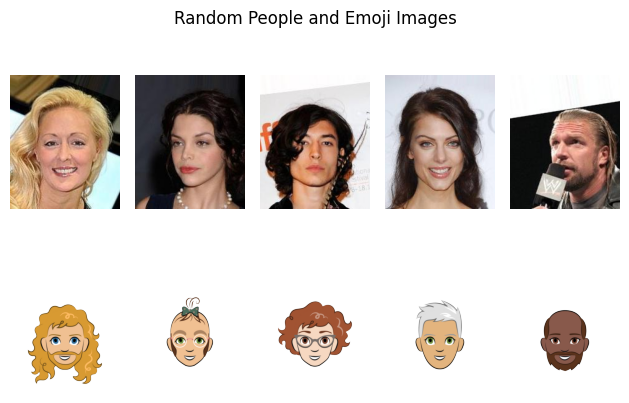

In [10]:
people_train_dir = (
    "/Users/varunguttikonda/kaggle/cartoonify/data/processed/people_faces/train"
)
emoji_train_dir = (
    "/Users/varunguttikonda/kaggle/cartoonify/data/processed/cartoonset/train"
)

people_images = os.listdir(people_train_dir)
emoji_images = os.listdir(emoji_train_dir)

random_people_images = random.sample(people_images, 5)
random_emoji_images = random.sample(emoji_images, 5)

img_objs = [
    {"image": f"{people_train_dir}/{people_image_path}", "name": "people_image"}
    for people_image_path in random_people_images
] + [
    {"image": f"{emoji_train_dir}/{emoji_image_path}", "name": "emoji_image"}
    for emoji_image_path in random_emoji_images
]

figure = plt.figure(figsize=(30, 15))
plt.subplots(2, 5)
for img_obj_idx, img_obj in enumerate(img_objs, 1):
    img = Image.open(img_obj["image"])
    plt.subplot(2, 5, img_obj_idx)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Random People and Emoji Images")
plt.show()

## Training the GAN

After creating the data loaders, we will train the GAN on the CelebA dataset. We will use the CycleGAN architecture to generate Memojis that look like the faces in the dataset. We will train the GAN for a few epochs and visualize the generated Memojis.

### Loss Function
The CycleGAN model uses two loss functions - the adversarial loss and the cycle-consistency loss. 

#### Adversarial Loss
![alt text](https://miro.medium.com/v2/resize:fit:830/format:webp/1*ZbL4gNWevk3MAMsdD8hb4Q.png)  
The adversarial loss is used to train the generator to generate realistic images

#### Cyclic Loss
![alt text](https://miro.medium.com/v2/resize:fit:732/format:webp/1*MVcaP2rkO4X_0INtb9qHAg.png)  
The cycle-consistency loss is used to ensure that the generated images are consistent with the input images.


## Training the model

We will use `LightningModule` to train the model. This will help us to train the model in a more structured way. We will use the `Trainer` class to train the model. We will train the model for a few epochs and visualize the generated Memojis.

In [11]:
class GanModel(L.LightningModule):
    def __init__(self, g, f, disc_g, disc_f):
        super(GanModel, self).__init__()
        self.g = g
        self.f = f
        self.disc_g = disc_g
        self.disc_f = disc_f

    def configure_optimizers(self):
        optimizer = optim.Adam(
            list(self.g.parameters())
            + list(self.f.parameters())
            + list(self.disc_g.parameters())
            + list(self.disc_f.parameters()),
            lr=0.0002,
        )

        return optimizer

    def training_step(self, batch, batch_idx):
        people_img, emoji_img = batch

        fake_emoji = self.g(people_img)
        fake_people = self.f(emoji_img)

        # Create losses for g, f and cyclic
        forward_gen_loss = torch.pow(self.disc_g(fake_emoji) - 1, 2)
        forward_disc_loss = torch.pow(self.disc_g(emoji_img), 2) + torch.pow(
            self.disc_g(fake_emoji), 2
        )

        forward_loss = forward_gen_loss + forward_disc_loss

        backward_gen_loss = torch.pow(self.disc_f(fake_people) - 1, 2)
        backward_disc_loss = torch.pow(self.disc_f(people_img), 2) + torch.pow(
            self.disc_f(fake_people), 2
        )

        backward_loss = backward_gen_loss + backward_disc_loss

        cyclic_loss_first_component = torch.abs(self.f(fake_emoji) - people_img).sum()
        cyclic_loss_second_component = torch.abs(self.g(fake_people) - emoji_img).sum()

        cyclic_loss = (cyclic_loss_first_component + cyclic_loss_second_component) * 10

        # Calculate the total loss
        total_loss = forward_loss + backward_loss + cyclic_loss

        self.log_dict(
            {
                "total_loss": total_loss,
                "forward_loss": forward_loss,
                "backward_loss": backward_loss,
                "cyclic_loss": cyclic_loss,
            },
            prog_bar=True,
        )

        return total_loss

    def test_step(self, batch, batch_idx):
        people_img, emoji_img = batch

        fake_emoji = self.g(people_img)
        fake_people = self.f(emoji_img)

        # Create losses for g, f and cyclic
        forward_gen_loss = torch.pow(self.disc_g(fake_emoji) - 1, 2)
        forward_disc_loss = torch.pow(self.disc_g(emoji_img), 2) + torch.pow(
            self.disc_g(fake_emoji), 2
        )

        forward_loss = forward_gen_loss + forward_disc_loss

        backward_gen_loss = torch.pow(self.disc_f(fake_people) - 1, 2)
        backward_disc_loss = torch.pow(self.disc_f(people_img), 2) + torch.pow(
            self.disc_f(fake_people), 2
        )

        backward_loss = backward_gen_loss + backward_disc_loss

        cyclic_loss_first_component = torch.abs(self.f(fake_emoji) - people_img).sum()
        cyclic_loss_second_component = torch.abs(self.g(fake_people) - emoji_img).sum()

        cyclic_loss = (cyclic_loss_first_component + cyclic_loss_second_component) * 10

        # Calculate the total loss
        total_loss = forward_loss + backward_loss + cyclic_loss

        self.log_dict(
            {
                "total_loss": total_loss,
                "forward_loss": forward_loss,
                "backward_loss": backward_loss,
                "cyclic_loss": cyclic_loss,
            },
            prog_bar=True,
        )

        return total_loss

    def validation_step(self, batch, batch_idx):
        people_img, emoji_img = batch

        fake_emoji = self.g(people_img)
        fake_people = self.f(emoji_img)

        # Create losses for g, f and cyclic
        forward_gen_loss = torch.pow(self.disc_g(fake_emoji) - 1, 2)
        forward_disc_loss = torch.pow(self.disc_g(emoji_img), 2) + torch.pow(
            self.disc_g(fake_emoji), 2
        )

        forward_loss = forward_gen_loss + forward_disc_loss

        backward_gen_loss = torch.pow(self.disc_f(fake_people) - 1, 2)
        backward_disc_loss = torch.pow(self.disc_f(people_img), 2) + torch.pow(
            self.disc_f(fake_people), 2
        )

        backward_loss = backward_gen_loss + backward_disc_loss

        cyclic_loss_first_component = torch.abs(self.f(fake_emoji) - people_img).sum()
        cyclic_loss_second_component = torch.abs(self.g(fake_people) - emoji_img).sum()

        cyclic_loss = (cyclic_loss_first_component + cyclic_loss_second_component) * 10

        # Calculate the total loss
        total_loss = forward_loss + backward_loss + cyclic_loss

        self.log_dict(
            {
                "total_loss": total_loss,
                "forward_loss": forward_loss,
                "backward_loss": backward_loss,
                "cyclic_loss": cyclic_loss,
            },
            prog_bar=True,
        )

        return total_loss

In [12]:
g = DummyGenerator()
f = DummyGenerator()

disc_g = DummyDiscriminator()
disc_f = DummyDiscriminator()

gan_model = GanModel(g, f, disc_g, disc_f)

people_root_dir = (
    "/Users/varunguttikonda/kaggle/cartoonify/data/processed/people_faces/val"
)
emoji_root_dir = "/Users/varunguttikonda/kaggle/cartoonify/data/processed/cartoonset/"

data_module = PeopleEmojiDataModule(people_root_dir, emoji_root_dir, batch_size=1)

rich_progress_bar = pl_callbacks.RichProgressBar()
rich_summary = pl_callbacks.RichModelSummary()
model_pruner = pl_callbacks.ModelPruner()
timer = pl_callbacks.Timer()

trainer = L.Trainer(
    max_epochs=200,
    accelerator="auto",
    devices="auto",
    strategy="auto",
    callbacks=[rich_progress_bar, rich_summary, model_pruner, timer],
    check_val_every_n_epoch=5,
)

trainer.fit(gan_model, data_module)

## Sample Results

In [13]:
test_dl = data.DataLoader(
    DummyPeopleEmojiDataset(
        "/Users/varunguttikonda/kaggle/cartoonify/data/processed/people_faces/val",
        "/Users/varunguttikonda/kaggle/cartoonify/data/processed/cartoonset/train",
        PEOPLE_FACES_TRANSFORM,
        CARTOON_SET_TRANSFORM,
    ),
    batch_size=1,
    shuffle=True,
)

g.eval()
f.eval()

disc_g.eval()
disc_f.eval()

g = torch.load("/Users/varunguttikonda/kaggle/cartoonify/g.pt", weights_only=False)
f = torch.load("/Users/varunguttikonda/kaggle/cartoonify/f.pt")

disc_g = torch.load("/Users/varunguttikonda/kaggle/cartoonify/disc_g.pt")
disc_f = torch.load("/Users/varunguttikonda/kaggle/cartoonify/disc_f.pt")

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

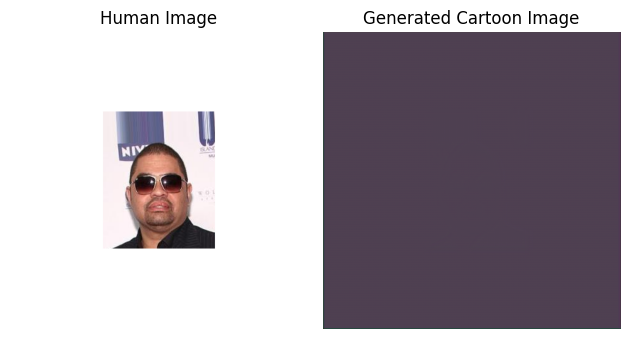

In [14]:
test_people_images, test_emoji_images = next(iter(test_dl))

test_people_images = test_people_images.to(DEVICE)
test_emoji_images = test_emoji_images.to(DEVICE)

g.to(DEVICE)

fake_emojis = g(test_people_images)

fake_emojis = fake_emojis.cpu()
test_people_images = test_people_images.cpu()
test_emoji_images = test_emoji_images.cpu()

# Plot the images
actual_image = test_people_images[0] / 255.0
figure = plt.figure(figsize=(30, 15))
plt.figure(figsize=(30, 15))
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(actual_image.permute(1, 2, 0).numpy())
plt.title("Human Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(fake_emojis[0].permute(1, 2, 0).detach().numpy())
plt.title("Generated Cartoon Image")
plt.axis("off")
plt.tight_layout()
plt.show()

## Learnings and Conclusion
1.	Most basic cloud offerings don’t work. Be ready to spend money. When working on scale, it is better to optimize for money or use cloud-managed services.
2.	Don’t write the code for multi-device logic. Use tools like Lightning AI to modularize your code. Lightning AI takes care of moving between devices and other logic, allowing you to focus on the core logic.
3.	Keep monitoring your metrics. This helps to save money and preempt training thus reducing your experiment time. Neptune is a good option to monitor your experiments.
4.	Keep your image size and batch size in mind. If your image size is too large (e.g. 1024 x 1024), then your batch size will be limited to 1, which is very inefficient use of compute and storage.

To conclude, a complete model couldn’t be trained for the limitations of resources and other constraints. But the process of building this project proved to be invaluable and taught a lot of things that go into building a machine learning model in a professional and academic setting.
